<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo">
    </a>
</p>


# Test Environment for Generative AI classroom labs

This lab provides a test environment for the codes generated using the Generative AI classroom.

Follow the instructions below to set up this environment for further use.


# Setup


### Install required libraries

In case of a requirement of installing certain python libraries for use in your task, you may do so as shown below.


In [ ]:
%pip install seaborn
import piplite

await piplite.install(['nbformat', 'plotly'])

### Dataset URL from the GenAI lab
Use the URL provided in the GenAI lab in the cell below. 


In [3]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv"

### Downloading the dataset

Execute the following code to download the dataset in to the interface.

> Please note that this step is essential in JupyterLite. If you are using a downloaded version of this notebook and running it on JupyterLabs, then you can skip this step and directly use the URL in pandas.read_csv() function to read the dataset as a dataframe


In [4]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

path = URL

await download(path, "dataset.csv")

---


# Test Environment


In [26]:
# Keep appending the code generated to this cell, or add more cells below this to execute in parts

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pyodide.http import pyfetch

# Función para descargar el dataset
async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

# Reemplaza 'your_url' con la URL de tu dataset
URL = URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0271EN-SkillsNetwork/labs/v1/m3/data/used_car_price_analysis.csv"
filename = "dataset.csv"

# Descargar el dataset
await download(URL, filename)

# Cargar el dataset desde el archivo descargado
data = pd.read_csv(filename)
print(data.head())


     model  year transmission  mileage fuelType    tax   mpg  engineSize  \
0   Fiesta  2017    Automatic    15944   Petrol  150.0  57.7         1.0   
1    Focus  2018       Manual     9083   Petrol  150.0  57.7         1.0   
2    Focus  2017       Manual    12456   Petrol  150.0  57.7         1.0   
3   Fiesta  2019       Manual    10460   Petrol  145.0  40.3         1.5   
4   Fiesta  2019    Automatic     1482   Petrol  145.0  48.7         1.0   

   price  
0  12000  
1  14000  
2  13000  
3  17500  
4  16500  


In [27]:
# Paso 1: Limpieza de datos
# Identificar y llenar valores faltantes con la media de las columnas numéricas
numeric_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'price']
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Eliminar duplicados
data = data.drop_duplicates()

# Verificar si hay valores nulos
print("Valores nulos por columna:\n", data.isnull().sum())

Valores nulos por columna:
 model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64


Los 5 atributos con mayor correlación con el precio son:
 price         1.000000
year          0.635715
mileage       0.530483
engineSize    0.411451
tax           0.405970
mpg           0.346263
Name: price, dtype: float64
Número de coches por tipo de combustible:
 fuelType
Petrol      12081
Diesel       5706
Hybrid         22
Electric        2
Other           1
Name: count, dtype: int64


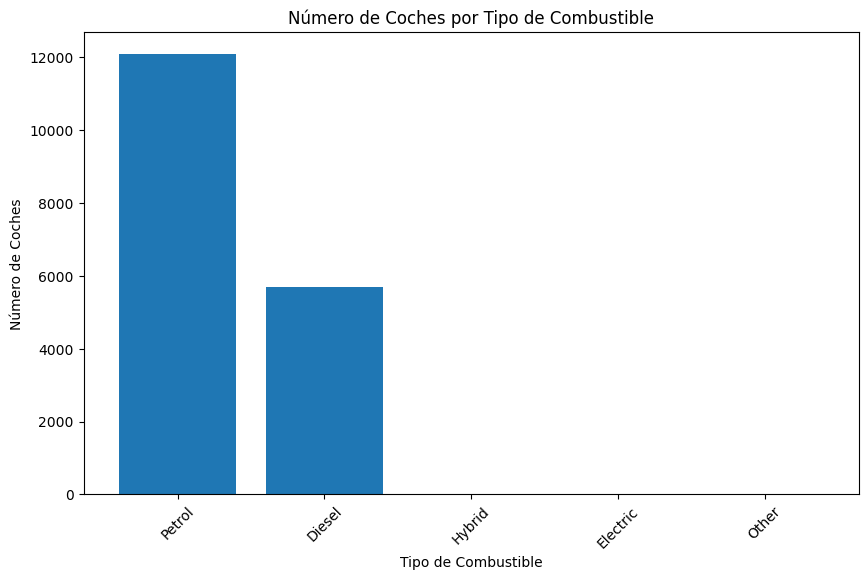

<Figure size 1000x600 with 0 Axes>

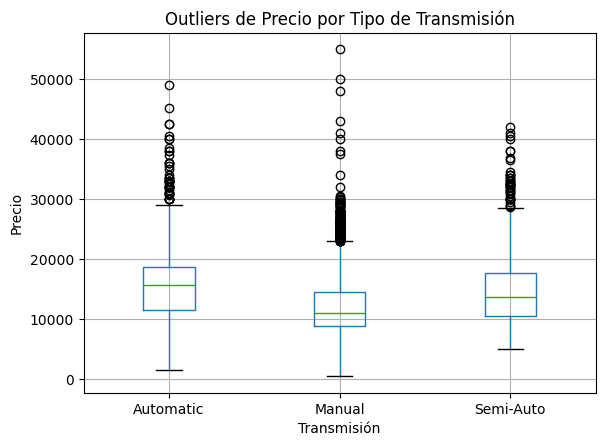

Cantidad de outliers por tipo de transmisión:
 transmission
Automatic     44
Manual       193
Semi-Auto     41
Name: price, dtype: int64


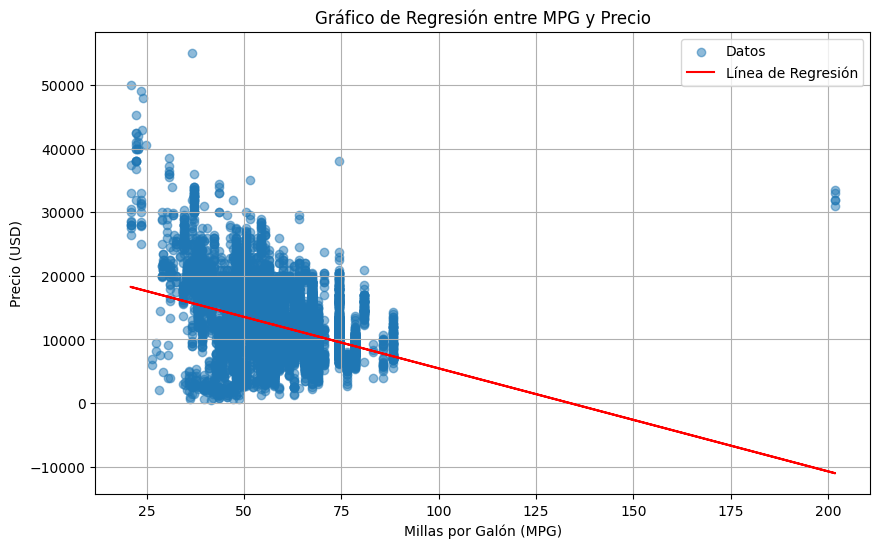

R²: 0.1199


In [28]:
# Paso 2: Análisis exploratorio de datos (EDA)
# a. Identificar los 5 atributos con mayor correlación con el precio
correlation = data[numeric_cols].corr()
top_correlations = correlation['price'].abs().nlargest(6)  # Incluye 'price' en la lista
print("Los 5 atributos con mayor correlación con el precio son:\n", top_correlations)

# b. Contar el número de coches por tipo de combustible
fuel_counts = data['fuelType'].value_counts()
print("Número de coches por tipo de combustible:\n", fuel_counts)

# Visualización de número de coches por tipo de combustible
plt.figure(figsize=(10, 6))
plt.bar(fuel_counts.index, fuel_counts.values)
plt.title('Número de Coches por Tipo de Combustible')
plt.xlabel('Tipo de Combustible')
plt.ylabel('Número de Coches')
plt.xticks(rotation=45)
plt.show()

# c. Crear un Box plot para analizar outliers por tipo de transmisión
plt.figure(figsize=(10, 6))
data.boxplot(column='price', by='transmission')
plt.title('Outliers de Precio por Tipo de Transmisión')
plt.suptitle('')  # Ocultar el título por defecto que añade pandas
plt.xlabel('Transmisión')
plt.ylabel('Precio')
plt.show()


# Calcular la cantidad de outliers por tipo de transmisión
def count_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((col < lower_bound) | (col > upper_bound)).sum()

# Agrupar y contar outliers directamente sin aplicar sobre el DataFrame agrupado
outliers_counts = data.groupby('transmission')['price'].apply(count_outliers)
print("Cantidad de outliers por tipo de transmisión:\n", outliers_counts)

# d. Generar el gráfico de regresión entre mpg y price
x = data['mpg']
y = data['price']
slope, intercept = np.polyfit(x, y, 1)  # Ajuste lineal

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Datos')  # Puntos de datos
plt.plot(x, slope * x + intercept, color='red', label='Línea de Regresión')  # Línea de regresión
plt.title('Gráfico de Regresión entre MPG y Precio')
plt.xlabel('Millas por Galón (MPG)')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()
plt.show()

# Calcular R²
r_value, _ = stats.pearsonr(data['mpg'], data['price'])
r_squared = r_value ** 2
print(f"R²: {r_squared:.4f}")

In [29]:
#paso 3
# Model Development and Evaluation

# a. Ajustar un modelo de regresión lineal usando mpg
X1 = data[['mpg']]
y = data['price']
model1 = LinearRegression()
model1.fit(X1, y)
y_pred1 = model1.predict(X1)

r2_1 = r2_score(y, y_pred1)
mse_1 = mean_squared_error(y, y_pred1)
print(f"Modelo 1 - R²: {r2_1:.4f}, MSE: {mse_1:.4f}")

# b. Ajustar un modelo de regresión lineal usando year, mileage, tax, mpg, y engineSize
X2 = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
model2 = LinearRegression()
model2.fit(X2, y)
y_pred2 = model2.predict(X2)

r2_2 = r2_score(y, y_pred2)
mse_2 = mean_squared_error(y, y_pred2)
print(f"Modelo 2 - R²: {r2_2:.4f}, MSE: {mse_2:.4f}")

# c. Crear un pipeline con estandarización, polinomios de segundo grado y regresión lineal
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

pipeline.fit(X2, y)
y_pred_pipeline = pipeline.predict(X2)

r2_pipeline = r2_score(y, y_pred_pipeline)
mse_pipeline = mean_squared_error(y, y_pred_pipeline)
print(f"Modelo Pipeline - R²: {r2_pipeline:.4f}, MSE: {mse_pipeline:.4f}")

# d. Dividir los datos en entrenamiento y prueba, y ajustar un modelo de Ridge
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

r2_ridge = ridge_model.score(X_test, y_test)
print(f"Modelo Ridge - R² en test: {r2_ridge:.4f}")

# e. Transformar los datos a polinomios de segundo orden y ajustar un modelo de Ridge
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

ridge_model_poly = Ridge(alpha=0.1)
ridge_model_poly.fit(X_train_poly, y_train)

y_pred_ridge_poly = ridge_model_poly.predict(X_test_poly)
r2_ridge_poly = r2_score(y_test, y_pred_ridge_poly)
mse_ridge_poly = mean_squared_error(y_test, y_pred_ridge_poly)
print(f"Modelo Ridge con polinomios - R²: {r2_ridge_poly:.4f}, MSE: {mse_ridge_poly:.4f}")

# f. Búsqueda en cuadrícula para Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=4)
grid_search.fit(X_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']
best_ridge_model = grid_search.best_estimator_
best_r2 = best_ridge_model.score(X_test_poly, y_test)
print(f"Mejor alpha: {best_alpha}, R² en test: {best_r2:.4f}")


Modelo 1 - R²: 0.1199, MSE: 19741690.8094
Modelo 2 - R²: 0.7265, MSE: 6134065.2244
Modelo Pipeline - R²: 0.7667, MSE: 5234038.0655
Modelo Ridge - R² en test: 0.6917


/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.17676e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Modelo Ridge con polinomios - R²: 0.6733, MSE: 7326174.5166


/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.93807e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.88233e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.01744e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.78199e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.93807e-24): res

Mejor alpha: 0.01, R² en test: 0.3827


In [30]:
# Paso 4: Búsqueda de Hiperparámetros para Ridge
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f'Mejores parámetros para Ridge: {grid_search.best_params_}')
best_ridge_model = grid_search.best_estimator_
y_pred_best_ridge = best_ridge_model.predict(X_test)
print(f'RMSE (Ridge Optimizado): {np.sqrt(mean_squared_error(y_test, y_pred_best_ridge))}')

# Visualización de resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_ridge)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones con Valores Reales')
plt.show()

Mejores parámetros para Ridge: {'alpha': 0.1}
RMSE (Ridge Optimizado): 2629.206306293769


<Figure size 1000x600 with 0 Axes>

<class 'NameError'>: name 'sns' is not defined

## Authors


[Abhishek Gagneja](https://www.linkedin.com/in/abhishek-gagneja-23051987/)


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-12-10|0.1|Abhishek Gagneja|Initial Draft created|


Copyright © 2023 IBM Corporation. All rights reserved.
